In [19]:
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Loading and preprocessing the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
X = lfw_people.images
y = lfw_people.target

# Extracting HOG features
hog_features = []
for image in X:
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(4,4),
                               cells_per_block=(2,2), visualize=True)
    hog_features.append(features)

# Splitting
X_hog = np.array(hog_features)
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.15, random_state=42)
print("HOG Features :",X_train.shape)


HOG Features : (1510, 3168)


In [20]:
class PCA_class:
  def __init__(self,n_components=None):
    # To initialize a PCA object

    # Total number of reduced features in projected data
    self.n_components = n_components
    self.eigenvalues = None
    self.eigenvectors=None
    self.means=None

  def fit(self,X):
    # To fit the model and finding principal components given an array X.
    if self.n_components==None:
      self.n_components=X.shape[0]
    self.means = np.mean(X,axis=0)
    X_mean = X-self.means
    cov_matrix = (X_mean.T @ X_mean)/X_mean.shape[0]
    cov_matrix = (cov_matrix + cov_matrix.T)/2
    self.eigenvalues, self.eigenvectors = np.linalg.eig(cov_matrix)
    self.eigenvalues = np.abs(np.real(self.eigenvalues))
    self.eigenvectors = np.real(self.eigenvectors)

    # (v) Sort eigenvectors based on eigenvalues
    # print(eigenvalues[eigenvalues<0])
    sorted_indices = np.argsort(self.eigenvalues)[::-1]
    self.eigenvalues = self.eigenvalues[sorted_indices]
    self.eigenvectors = self.eigenvectors[:, sorted_indices]
    self.eigenvectors = self.eigenvectors/np.sqrt((np.sum(self.eigenvectors*self.eigenvectors, axis=0)))
    return X_mean @ self.eigenvectors[:,:self.n_components]

  def fit_transform(self,X):
    # returns the given array after projected it along principal components
    return (X-self.means) @ self.eigenvectors[:,:self.n_components]


  def explained_variance(self):
    # returns first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]
  def explained_variance_ratio(self):
    # returns ratio of variance captured by first 'n_components' number of eigen values in decreasing order
    return self.eigenvalues[:self.n_components]/np.sum(self.eigenvalues)

  def components(self):
    # returns principal components
    return self.eigenvectors[:,:self.n_components]

  def get_eigenvalues(self):
    # returns all eigen values
    return self.eigenvalues
  def get_eigenvectors(self):
    # returns all eigenvectors
    return self.eigenvectors

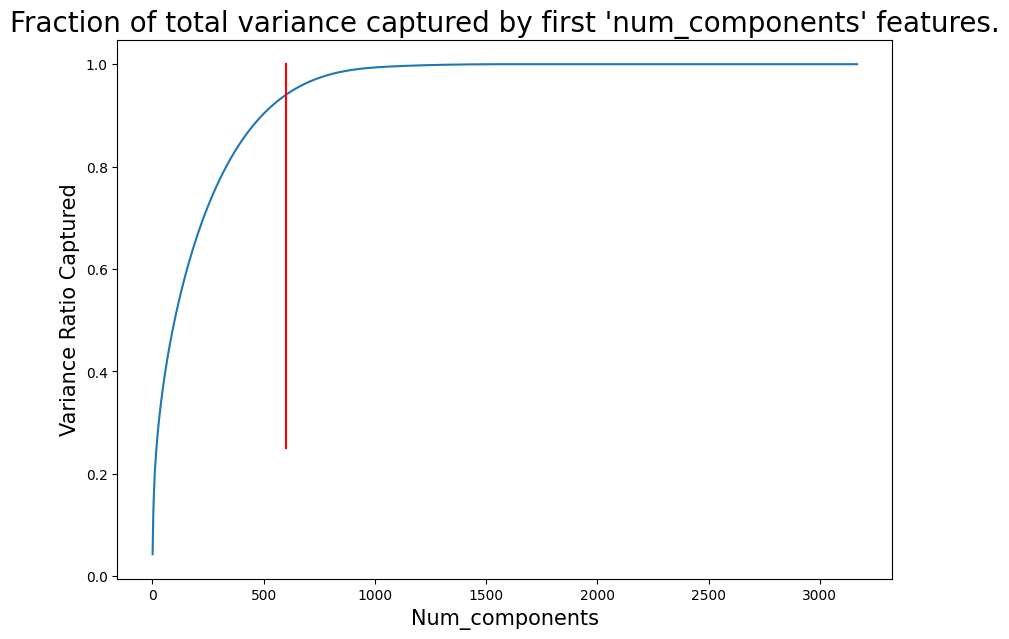

In [23]:
num_components=600   # To reduce the data into 200 features.

pca = PCA_class(n_components=num_components)
X_projected = pca.fit(X_train)
X_test_projected = pca.fit_transform(X_test)
principal_components = pca.components()
# Convert principal components back to eigen faces.
# eigenfaces = (principal_components.T).reshape((principal_components.shape[1],50,37))

# Reconstruct the original data from the extracted features.
# X_reconstructed = (X_projected @ (principal_components.T)) + np.mean(X_train,axis=0)

# To plot the graph of total variance captured by first 'num_components' eigen vectors.
x = np.arange(1,X_train.shape[1]+1,1)
y = np.cumsum(pca.get_eigenvalues())/np.sum(pca.get_eigenvalues())
plt.figure(figsize=(10,7))
plt.plot(x,y)

x = [num_components,num_components]
y = [0.25,1]
plt.plot(x,y,'r')
plt.title("Fraction of total variance captured by first 'num_components' features.",size=20)
plt.xlabel("Num_components",size=15)
plt.ylabel("Variance Ratio Captured",size=15)
plt.show()

Linear Kernel Accuracy : 0.8539325842696629


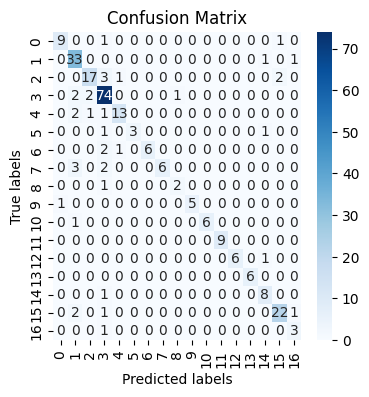

Best parameters for Poly Kernel :  {'degree': 2, 'gamma': 0.21544346900318834}
Polynomial Kernel Accuracy :  0.6629213483146067


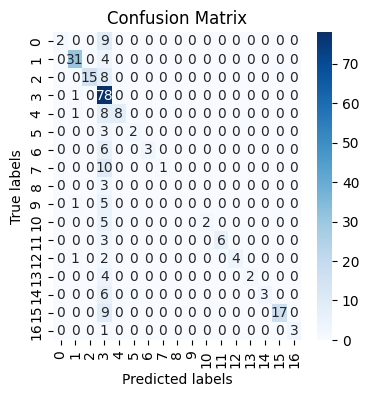

Best parameters for RBF Kernel :  {'C': 10.0, 'gamma': 0.01}
RBF Kernel Accuracy :  0.8838951310861424


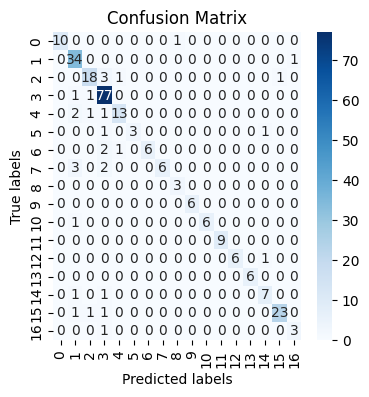

In [3]:
## Linear Kernel SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Linear Kernel Accuracy :",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Polynomial Kernel SVM
param_grid = {
              'degree' : [2,3,4],
              'gamma': np.logspace(-2,2,4)}
svm = SVC(kernel='poly')
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters for Poly Kernel : ", best_params)
y_pred = grid_search.best_estimator_.predict(X_test)
print("Polynomial Kernel Accuracy : ",accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# RBF Kernel SVM
param_grid = {
              'C': np.logspace(-1,3,5),
              'gamma': np.logspace(-3,1,5)}
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters for RBF Kernel : ", best_params)
y_pred = grid_search.best_estimator_.predict(X_test)
print("RBF Kernel Accuracy : ", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()